<a href="https://colab.research.google.com/github/AyeshW/TaxiFare/blob/master/Trip_Fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [0]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)

In [0]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [0]:
label_df = pd.DataFrame(df['label'])
feature_df = df.drop(columns='label')
feature_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39


In [0]:
label_df['label_copy'] = label_df['label']
labels ={"label": {"correct": 1, "incorrect": 0}}
label_df.replace(labels, inplace=True)
label_df.head()

,label,label_copy
tripid,,
189123628,1,correct
189125358,1,correct
189125719,1,correct
189127273,1,correct
189128020,1,correct


In [0]:
label_df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [0]:
label_df.drop(columns='label_copy', inplace=True)
label_df.head()

,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1


In [0]:
def set_trip_time(df):
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()
    df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

set_trip_time(feature_df)
feature_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,trip_time
tripid,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,840.0
189125358,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,780.0
189125719,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,1080.0
189127273,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,600.0
189128020,NaN,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,358.39,1020.0


In [0]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)

def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances
    feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], inplace=True)

# Calling the set_distance to set a distance column and remove coordinates columns
set_distance(feature_df)
feature_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,trip_time,trip_distance
tripid,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,840.0,5.093
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,780.0,3.168
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1080.0,6.305
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,600.0,0.862
189128020,NaN,NaN,NaN,NaN,NaN,358.39,1020.0,8.148


In [0]:
feature_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,trip_time,trip_distance
count,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17039.000000,17176.000000,17176.000000
mean,13.719651,1702.858077,629.074231,32.057666,112.466832,312.655466,1713.929902,4.858258
std,98.975052,8120.160818,8063.260669,465.483573,442.054812,605.300565,8101.459112,43.015847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,125.515000,540.000000,1.486000
50%,10.500000,1009.500000,123.000000,0.116600,73.000000,211.180000,1020.000000,3.218000
75%,10.500000,1803.000000,351.000000,14.341800,144.000000,366.465000,1800.000000,6.161250
max,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,26945.990000,453840.000000,5609.521000


In [0]:
def set_time_error(feature_df):
    time_errors = []
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2
    #feature_df.drop(columns=['duration', 'trip_time'], inplace=True)

set_time_error(feature_df)
feature_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,trip_time,trip_distance,time_error
tripid,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,840.0,5.093,36.0
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,780.0,3.168,121.0
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1080.0,6.305,49.0
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,600.0,0.862,4.0
189128020,NaN,NaN,NaN,NaN,NaN,358.39,1020.0,8.148,NaN


In [0]:
def feature_process(feature_df):
    set_trip_time(feature_df)
    set_distance(feature_df)
    set_time_error(feature_df)

In [0]:
(feature_df.shape, label_df.shape)

((17176, 9), (17176, 1))

In [0]:
feature_df.dtypes

additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
fare                         float64
trip_time                    float64
trip_distance                float64
time_error                   float64
dtype: object

In [0]:
feature_df.isnull().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
fare                         137
trip_time                      0
trip_distance                  0
time_error                   202
dtype: int64

# Visualizing Data


In [0]:
%%script false --no-raise-error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

imputer = SimpleImputer()
data = imputer.fit_transform(feature_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

temp_df = pd.DataFrame({'x': pca_result[:,0], 'y': pca_result[:,1], 'label': label_df['label']})

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(temp_df.shape[0])

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=temp_df,
    legend="full",
    alpha=0.6
)

# Building Models

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

## Setting-up the Pre-Processor

In [0]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

# SimpleImputer(strategy='median', add_indicator=False) - RandomForest model
# SimpleImputer(strategy='median', add_indicator=True) - LogisticRegression
# SimpleImputer(strategy='most_frequent', add_indicator=True) -XGBClassifier
preprocessor = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', MinMaxScaler())
])

## Selecting the best model

In [0]:
%%script false --no-raise-error
models = [
    XGBClassifier(max_depth=7, learning_rate=0.01, n_estimators=500, eval_metric='rmse') #, objective='binary:hinge'
    #RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6),
    #LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
    #MultinomialNB(),
    #BernoulliNB(),
    #LogisticRegression(random_state=0),
    #SGDClassifier(),
    #LinearSVC()
]

processed_models = {}
for model in models:
    name = model.__class__.__name__
    processed_models[name] = Pipeline([("preprocessor", preprocessor),
                                      ("estimator", model)])
    
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for (name, model) in processed_models.items():
  f1_scores = cross_val_score(model, feature_df, label_df.label, scoring='f1_macro', cv=CV)
  for fold_idx, f1 in enumerate(f1_scores):
    entries.append((name, fold_idx, f1))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])

print(cv_df)
print(cv_df.groupby('model_name').f1_score.mean())

## Hyper-Parameter Tuning

## Grid Search

In [0]:
%%script false --no-raise-error
# RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6, n_jobs=-1)
# LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", XGBClassifier(booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae')),
])

# estimator parameter tuning - Random Forest
criterion = ['gini', 'entropy']
n_estimators = [100, 200, 300, 50]
max_depth = [3, 5, 10, 15]
max_features = [5, 'log2', 'auto']
min_impurity_decrease = [0, 0.2, 0.5, 1.0]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]

param_grid1 = dict(estimators__criterion =criterion,
                  estimators__n_estimators =n_estimators,
                  estimators__max_depth=max_depth,
                  estimators__max_features =max_features,
                  estimators__min_impurity_decrease=min_impurity_decrease,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - Linear Regression
penalty = ['l1', 'l2'] # , 'elasticnet'
C = [0.001, 0.01, 0.1, 1, 10, 100]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [100, 200, 300]

param_grid2 = dict(estimators__penalty = penalty,
                  estimators__C = C,
                  estimators__max_iter = max_iter,
                  estimators__solver = solver,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - XGBoost
booster = ['gbtree', 'dart']
max_depth = [5, 8, 10]
learning_rate = [0.01, 0.05, 0.1, 0.4]
n_estimators = [500, 800, 1000]
eval_metric = ['rmse', 'mae', 'logloss']
objective = ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge']

param_grid3 = dict(estimators__booster = booster,
                   estimators__max_depth = max_depth,
                   estimators__learning_rate = learning_rate,
                   estimators__n_estimators = n_estimators,
                   estimators__eval_metric = eval_metric,
                   estimators__objective = objective)

# preprocessor parameter tuning
strategy = ['mean', 'median', 'most_frequent']
indicator = [True, False]
param_grid4 = dict(preprocessor__simple_imputer__strategy = strategy,
                   preprocessor__simple_imputer__add_indicator = indicator)

X_trainc, X_evalc, y_trainc, y_evalc = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

grid = GridSearchCV(estimator=cross_pipeline,
                    param_grid=param_grid4,
                    scoring='f1_macro',
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_trainc, y_trainc)

print("Model: Random Forest")
print("Best param: ",grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
#print(cross_pipeline.get_params().keys())

# Random Search

In [0]:
#%%script false --no-raise-error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:logistic',
                      silent=True, nthread=6, tree_method='hist', eval_metric='auc')),
])

# estimator parameter tuning - XGBoost
booster = ['gbtree', 'dart']
max_depth = [5, 6, 8, 10, 12]
learning_rate = [0.01, 0.03, 0.05, 0.1, 0.2]
n_estimators = [500, 800, 1000]
eval_metric = ['rmse', 'mae', 'logloss']
objective = ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge']

param_grid1 = dict(estimators__booster = booster,
                   estimators__max_depth = max_depth,
                   estimators__learning_rate = learning_rate,
                   estimators__n_estimators = n_estimators,
                   estimators__eval_metric = eval_metric,
                   estimators__objective = objective)

param_grid2={
  "estimators__learning_rate"    : [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 ] ,
  "estimators__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
  "estimators__min_child_weight" : [ 1, 3, 5, 7 ],
  "estimators__subsample"        : [0.8, 0.9, 1.0],
  "estimators__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
  "estimators__colsample_bytree" : [ 0.7, 0.8, 0.9, 1 ]
 }

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

random_grid = RandomizedSearchCV(estimator=cross_pipeline, 
                                 param_distributions = param_grid2, 
                                 n_iter=10, 
                                 scoring='f1_macro', 
                                 n_jobs=4, 
                                 cv=skf.split(feature_df,label_df), 
                                 verbose=3, 
                                 random_state=1001)

random_grid.fit(feature_df, label_df)
print("Best Params: ", random_grid.best_params_)
print("Best Estimator: ", random_grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 17.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Params:  {'estimators__subsample': 0.8, 'estimators__min_child_weight': 1, 'estimators__max_depth': 4, 'estimators__learning_rate': 0.05, 'estimators__gamma': 0.2, 'estimators__colsample_bytree': 1}
Best Estimator:  Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('simple_imputer',
                                  SimpleImputer(add_indicator=True, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='median', verbose=0)),
                                 ('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('estimators',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                            

In [0]:
random_grid.best_score_

0.8427821584515603

# Train & Evaluation

In [0]:
#estimator=RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6)
#estimator = LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
# XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse') #, objective='binary:hinge'
#subsample=0.8, min_child_weight=1, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=1, n_estimators=1000, objective='binary:logistic', silent=True, nthread=6, tree_method='hist', eval_metric='auc'

estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=7, max_depth=15, learning_rate=0.01, gamma=0.4, colsample_bytree=1,
                          colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logistic',
                      importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
                      njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='auc', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
                      validate_parameters=False)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

In [0]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
print(preds)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1 1 1 ... 1 0 1]
CPU times: user 16min 18s, sys: 8.7 s, total: 16min 26s
Wall time: 8min 25s


In [0]:
%%script false --no-raise-error
# Submission 3
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9728376035445965
Macro F1_Score: 0.8389292620233442


In [0]:
%%script false --no-raise-error
# Submission 4 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae'
# Imputer - most_frequent
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9719752609199845
Macro F1_Score: 0.8395229839953459


In [0]:
%%script false --no-raise-error
# Submission 4 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae'
# Imputer - median
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9720745965793796
Macro F1_Score: 0.8399301193210346


In [0]:
%%script false --no-raise-error
# Submission 5/6 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=10, learning_rate=0.03, eval_metric='mae'
# Imputer - median 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9724717473196176
Macro F1_Score: 0.8415658228983875


In [0]:
# Submission xxx - XGB with half of the parameter tuning
# Imputer - median 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9713020030816641
Macro F1_Score: 0.8294665151676665


Text(0.5, 15.0, 'Predicted')

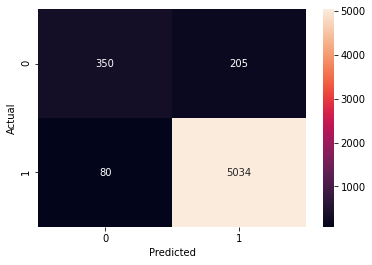

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_eval, preds)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Predicting on Test Data

In [0]:
%%time 

full_pipeline.fit(feature_df, label_df)
None

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 18min 43s, sys: 215 ms, total: 18min 43s
Wall time: 18min 44s


In [0]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

In [0]:
feature_process(test_features_df)
test_predictions = full_pipeline.predict(test_features_df)
test_predictions

array([1, 0, 1, ..., 1, 1, 1])

In [0]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_predictions

submission_df.head()

,prediction
tripid,
213284604,1
213286352,0
213293973,1
213294622,1
213298687,1


In [0]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/TaxiFare/my_submission.csv', index=True)

In [0]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/TaxiFare/my_submission.csv

tripid,prediction
213284604,1
213286352,0
213293973,1
213294622,1
213298687,1
213299545,1
213302332,1
213302671,1
213305594,1


In [0]:
dat = pd.DataFrame({'A': [12,34,56,78, 23,None, None], 'B': [90,80,70,23,None, 78, None]})
dat['B1'] = dat['B'].isnull()
dat['A1'] = dat['A'].isnull()
dat['ismissing'] = dat['A1'] == dat['B']
dat

,A,B,B1,A1,ismissing
0,12.0,90.0,False,False,False
1,34.0,80.0,False,False,False
2,56.0,70.0,False,False,False
3,78.0,23.0,False,False,False
4,23.0,NaN,True,False,False
5,NaN,78.0,False,True,False
6,NaN,NaN,True,True,False


In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 